# Grad-Cam Visualizations

this notebook we use the **Gradient-weighted Class Activation Mapping** (Grad-CAM, https://arxiv.org/abs/1610.02391) to produce visual explanations for decisions made by the CNN classifier, focusing on high-probability False Positive and False Negative examples.


### Import packages

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import random

# Colab in order to download files
from google.colab import files

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [2]:
# We have to install scipy==1.1.0 here in order for visualize cam to run properly
#!pip install scipy==1.1.0

In [3]:
# We also have to use an older version of tensorflow backend
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import backend as K

Using TensorFlow backend.


In [5]:
# Grad-CAM visualization package
from vis.visualization import visualize_cam
from vis.utils import utils

**Import datasets**

- `X_tr, X_val, X_test`: Refer to the training, validation and test sets for the image-based classification (deep learning). 

- `y_tr, y_val, y_test`: Labels - training, validation and test sets.

In [6]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# For image-based classification
X_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_train.npy")) #Training
X_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_val.npy")) #Validation
X_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_test.npy")) #Test

# Labels
y_tr = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_train.npy")) # Training
y_val = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_val.npy")) #Validation
y_test = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_test.npy")) #Test

## Build the Deep Learning model - DeepShadows

In [8]:
# build the  original model
model = keras.models.Sequential()
model.add(keras.layers.InputLayer((64,64,3)))
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer=optimizers.Adadelta(0.1),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
model.fit(x=X_tr, y=y_tr,
          epochs=100, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))

Train on 30000 samples, validate on 5000 samples
Epoch 1/100
30000/30000 [==============================] - 13s 430us/sample - loss: 54.1687 - acc: 0.8198 - val_loss: 6.0141 - val_acc: 0.8470
Epoch 2/100
30000/30000 [==============================] - 6s 200us/sample - loss: 2.4026 - acc: 0.8783 - val_loss: 1.1127 - val_acc: 0.8294
Epoch 3/100
30000/30000 [==============================] - 6s 201us/sample - loss: 0.7189 - acc: 0.8939 - val_loss: 0.5987 - val_acc: 0.8692
Epoch 4/100
30000/30000 [==============================] - 6s 202us/sample - loss: 0.4736 - acc: 0.9003 - val_loss: 0.4337 - val_acc: 0.8950
Epoch 5/100
30000/30000 [==============================] - 6s 206us/sample - loss: 0.3934 - acc: 0.9038 - val_loss: 0.3813 - val_acc: 0.8982
Epoch 6/100
30000/30000 [==============================] - 6s 207us/sample - loss: 0.3521 - acc: 0.9062 - val_loss: 0.3354 - val_acc: 0.9090
Epoch 7/100
30000/30000 [==============================] - 6s 206us/sample - loss: 0.3328 - acc: 0.9066

**Predict probabilities**

In [10]:
Probs = model.predict(X_test)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0

#### Case I: False Positives

Here we consider high-probability ($P>0.8$) false positives. We present examples and Grad-CAM visualizations. 

In [12]:
# Artefacts misclassified as LSBGs (False Positives)
X_misc_Art = X_test[(Probs[:,0]>0.8)&(y_test==0.0)] #Artefacts classified as LSBGs
print(np.shape(X_misc_Art))

(127, 64, 64, 3)


Plot misclassified

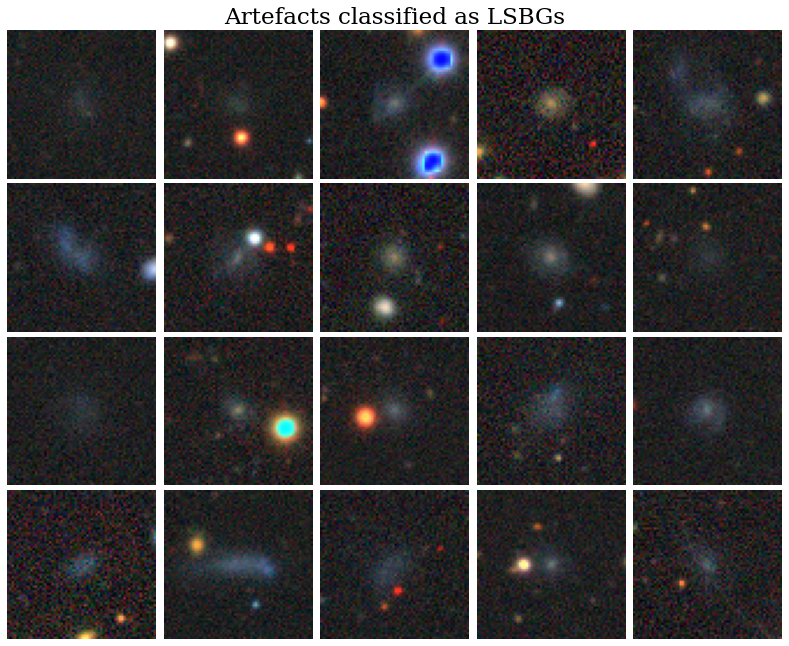

In [13]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Artefacts classified as LSBGs",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_Art[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_Art_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_Art_Examples.pdf")
plt.show()


Plot Grad-CAM 

In [14]:
# set channel_first data format in Keras backend in order for grad-CAM to work properly
K.set_image_data_format('channels_last')

# find the last convolutional layer
penultimate_layer = utils.find_layer_idx(model, 'conv2d_2')
class_idx = 0 # choose the class position in the output layer, here 0 since the output has just one dimention
layer_idx = 12 #utils.find_layer_idx(model, 'max_pooling2d_3')#11 # location of the output layer
#model.layers[layer_idx].activation = keras.activations.linear
#model = utils.apply_modifications(model)

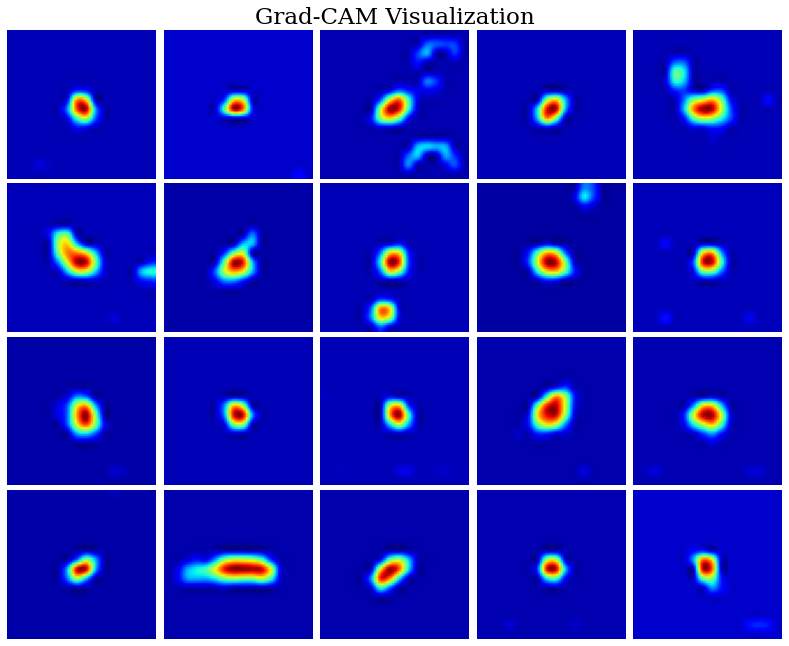

In [15]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Grad-CAM Visualization",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=X_misc_Art[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    plt.imshow(grads)
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_Art_GradCAM.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_Art_GradCAM.pdf")
plt.show()


#### Case II: False Negatives

Here we consider high-probability ($P<0.2$) false negatives. We present examples and Grad-CAM visualizations. 

In [16]:
X_misc_LSBG = X_test[(Probs[:,0]<0.2)&(y_test==1.0)] #LSBGs classified as Artefacts
print(np.shape(X_misc_LSBG))

(40, 64, 64, 3)


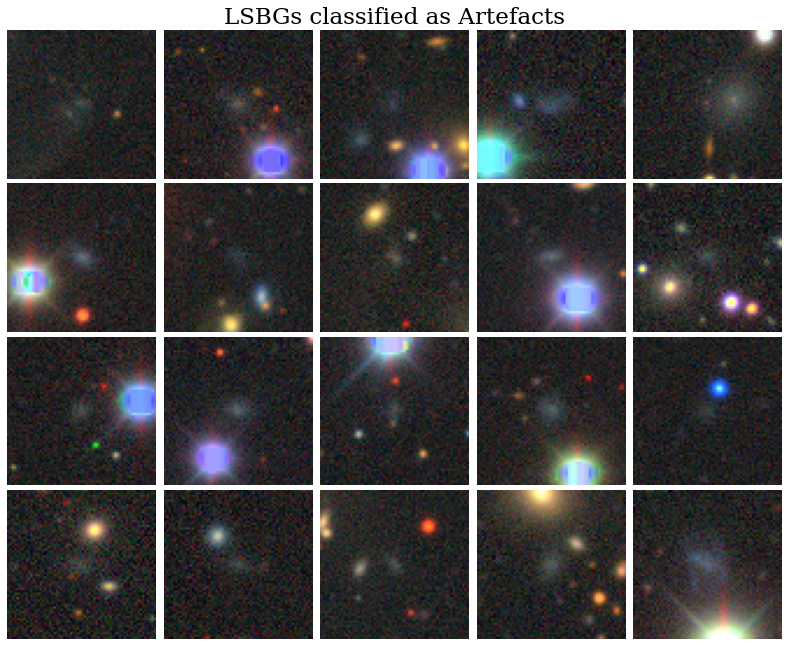

In [17]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("LSBGs classified as Artefacts",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_LSBG_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_LSBG_Examples.pdf")
plt.show()

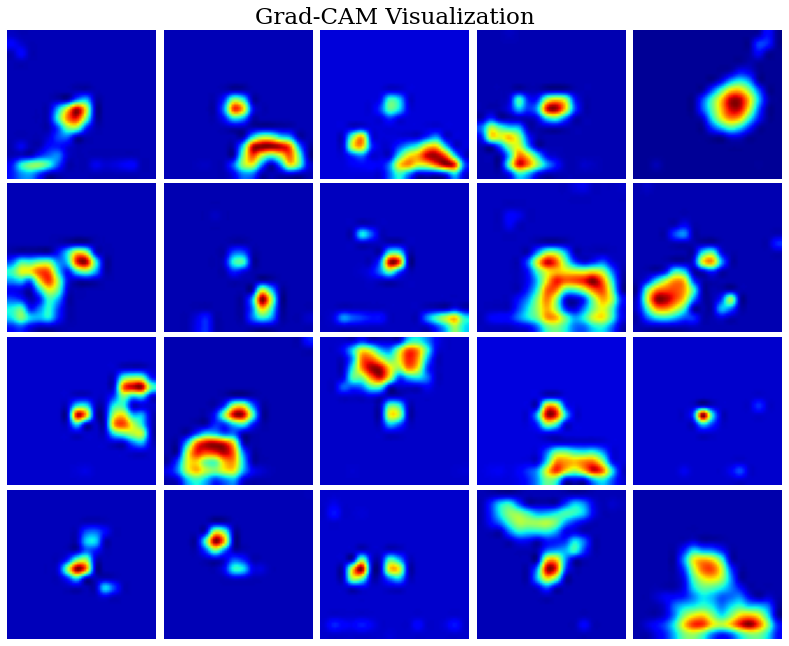

In [18]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Grad-CAM Visualization",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=X_misc_LSBG[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    plt.imshow(grads)
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_LSBG_GradCAM.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_LSBG_GradCAM.pdf")
plt.show()

#### Case III: True positives

Examples of correct classification but with low probability

LSBGs with $0.5<P<0.6$.

In [19]:
X_corr_LSBG = X_test[(Probs[:,0]>0.5)&(Probs[:,0]<0.6)&(y_test==1.0)] #LSBGs classified as LSBGs
print(np.shape(X_corr_LSBG))

(40, 64, 64, 3)


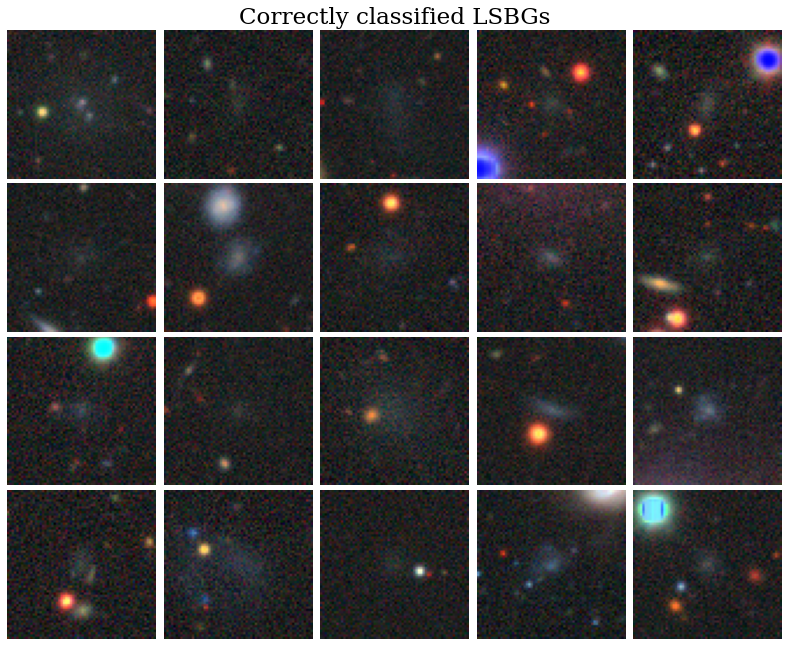

In [20]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Correctly classified LSBGs",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_corr_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Corr_LSBG_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/Corr_LSBG_Examples.pdf")
plt.show()

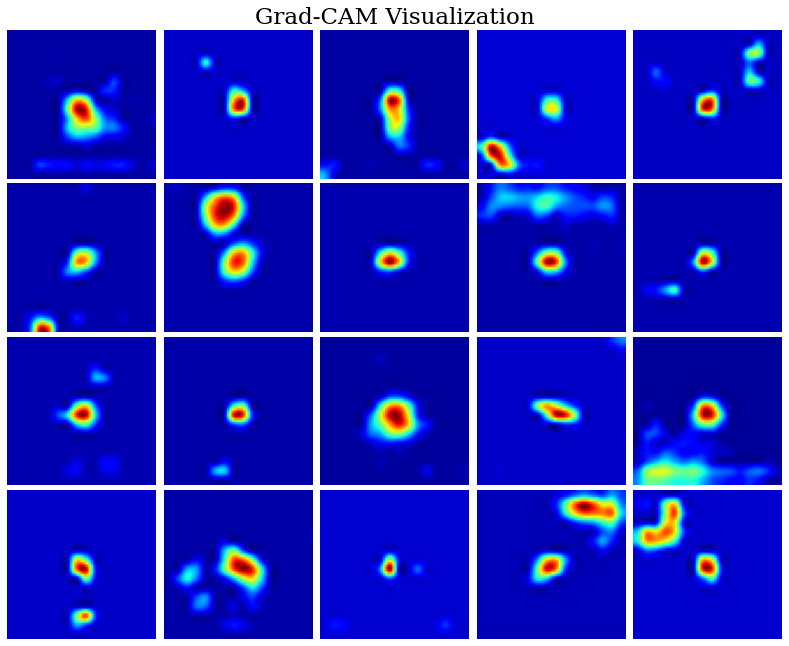

In [21]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Grad-CAM Visualization",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=X_corr_LSBG[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    plt.imshow(grads,cmap='viridis')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Corr_LSBG_GradCAM.pdf")
#files.download("/content/drive/My Drive/Plots/Corr_LSBG_GradCAM.pdf")
plt.show()

#### Case III: True negatives

Examples of correct classification but with low probability

Artefacts with $0.4<P<0.5$.

In [22]:
X_corr_Art = X_test[(Probs[:,0]>0.4)&(Probs[:,0]<0.5)&(y_test==0.0)] #Artefacts classified as LSBGs
print(np.shape(X_corr_Art))

(36, 64, 64, 3)


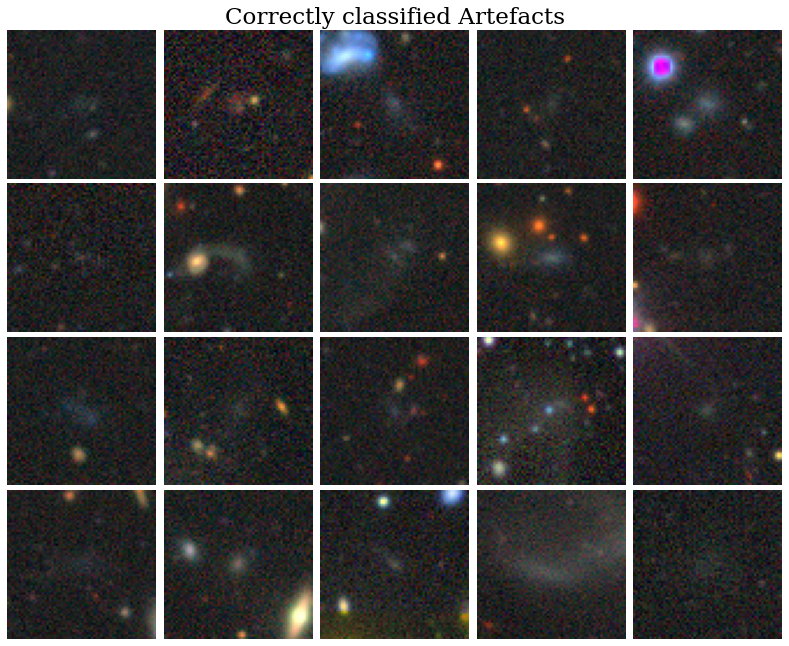

In [23]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Correctly classified Artefacts",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_corr_Art[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Corr_Art_Examples.pdf")
#files.download("/content/drive/My Drive/Plots/Corr_Art_Examples.pdf")
plt.show()

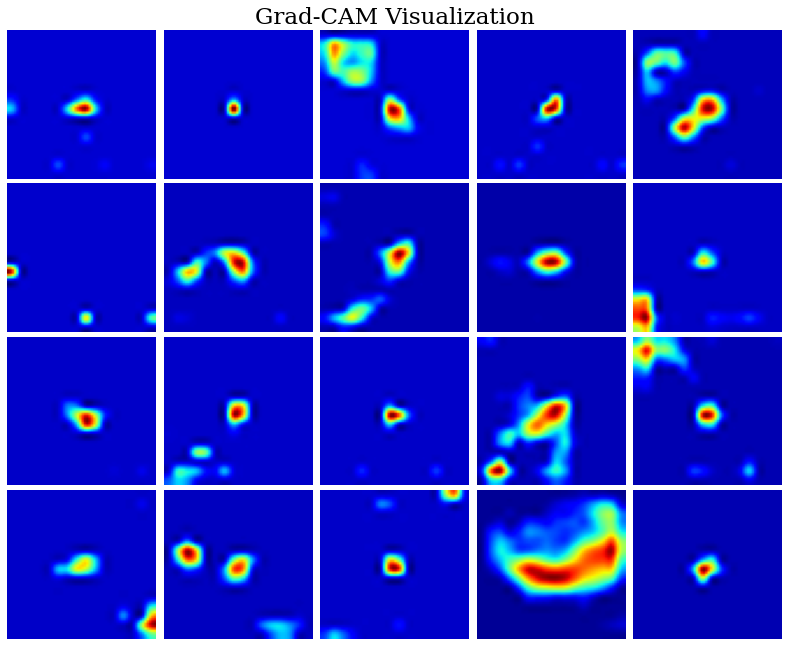

In [24]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Grad-CAM Visualization",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=X_corr_Art[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    plt.imshow(grads,cmap='viridis')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Corr_Art_GradCAM.pdf")
#files.download("/content/drive/My Drive/Plots/Corr_Art_GradCAM.pdf")
plt.show()

## Grad-CAM for the HSC results

Here we retrain on the HSC results, predict and make plots similar to the above for false positives and false negatives.


#### First, import the HSC dataset (training and test)

In [25]:
X_tr_HSC = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_train_HSC.npy")) #Training data
X_test_HSC = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/X_test_HSC.npy")) #Test data
# ======================================================================================
# ======================================================================================
y_tr_HSC = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_train_HSC.npy")) #Training labels
y_test_HSC = np.float64(np.load("/content/drive/My Drive/Galaxies_Data/y_test_HSC.npy")) #Test labels

Retrain  (fine-tune)

In [26]:
# Compile again the model, now with a much smaller learning rate
model.compile(optimizer=optimizers.Adadelta(0.005),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])
# =======================================================================
# =======================================================================
# Now train/fit
model.fit(x=X_tr_HSC, y=y_tr_HSC,
          epochs=30, batch_size=16,
          shuffle=True)

Train on 320 samples
Epoch 1/30
320/320 [==============================] - 1s 2ms/sample - loss: 0.4788 - acc: 0.8125
Epoch 2/30
320/320 [==============================] - 0s 431us/sample - loss: 0.4597 - acc: 0.8156
Epoch 3/30
320/320 [==============================] - 0s 447us/sample - loss: 0.4524 - acc: 0.8281
Epoch 4/30
320/320 [==============================] - 0s 438us/sample - loss: 0.4580 - acc: 0.8250
Epoch 5/30
320/320 [==============================] - 0s 442us/sample - loss: 0.4226 - acc: 0.8250
Epoch 6/30
320/320 [==============================] - 0s 427us/sample - loss: 0.4256 - acc: 0.8344
Epoch 7/30
320/320 [==============================] - 0s 431us/sample - loss: 0.4148 - acc: 0.8313
Epoch 8/30
320/320 [==============================] - 0s 430us/sample - loss: 0.4011 - acc: 0.8375
Epoch 9/30
320/320 [==============================] - 0s 425us/sample - loss: 0.4049 - acc: 0.8375
Epoch 10/30
320/320 [==============================] - 0s 433us/sample - loss: 0.4145 - ac

In [27]:
# Predict classes on the test set
y_pred_HSC = model.predict_classes(X_test_HSC)
# Predict probabilities
y_pred_proba_HSC = model.predict(X_test_HSC)

Get misclassification examples

In [28]:
# False positives
X_misc_HSC_Art = X_test_HSC[(y_pred_proba_HSC[:,0]>0.5)&(y_test_HSC==0.0)] #Artefacts classified as LSBGs
# False negatives
X_misc_HSC_LSBG = X_test_HSC[(y_pred_proba_HSC[:,0]<0.5)&(y_test_HSC==1.0)] #LSBGs classified as Artefacts

# ==============================
# Print sizes
print(np.shape(X_misc_HSC_Art)) 
print(np.shape(X_misc_HSC_LSBG))

(84, 64, 64, 3)
(36, 64, 64, 3)



#### Make plots: False positives

First let's make a plot of artefacts classified as LSBGs (False positives)



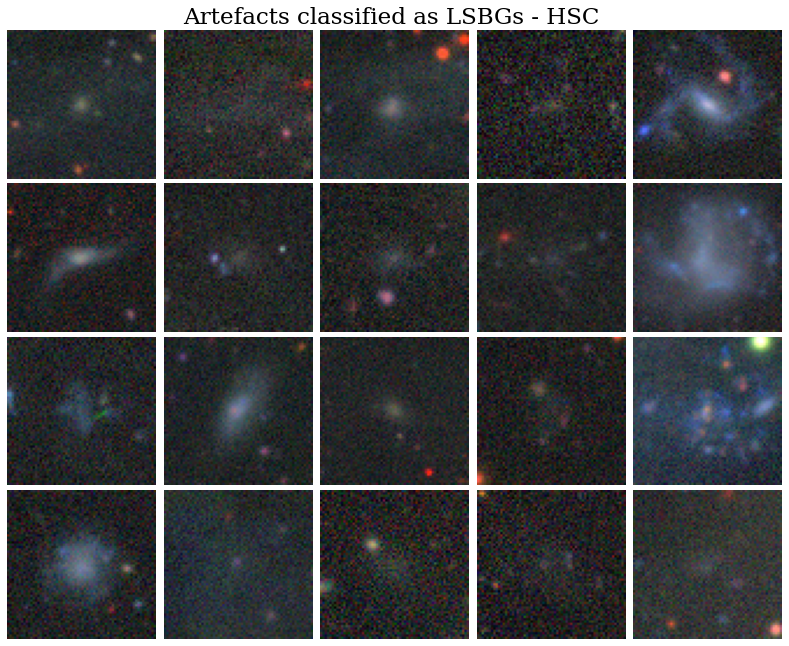

In [29]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Artefacts classified as LSBGs - HSC ",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_HSC_Art[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_Art_Examples_HSC.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_Art_Examples_HSC.pdf")
plt.show()

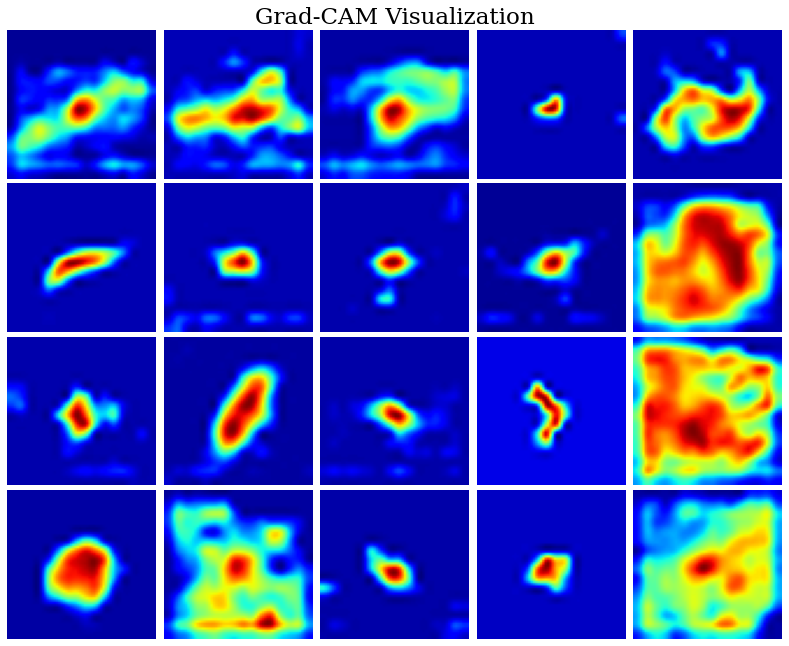

In [30]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Grad-CAM Visualization",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=X_misc_HSC_Art[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    plt.imshow(grads,cmap='viridis')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_Art_Examples_HSC_GradCAM.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_Art_Examples_HSC_GradCAM.pdf")
plt.show()

#### Make plots: False negatives

First let's make a plot of LSBGs classified as artefacts (False negatives)

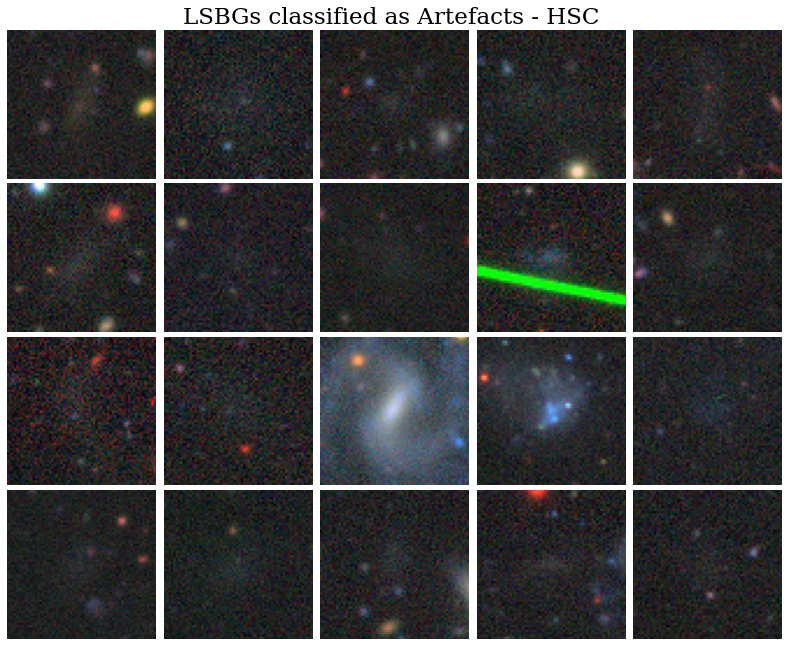

In [31]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("LSBGs classified as Artefacts - HSC ",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_misc_HSC_LSBG[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_LSBG_Examples_HSC.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_LSBG_Examples_HSC.pdf")
plt.show()


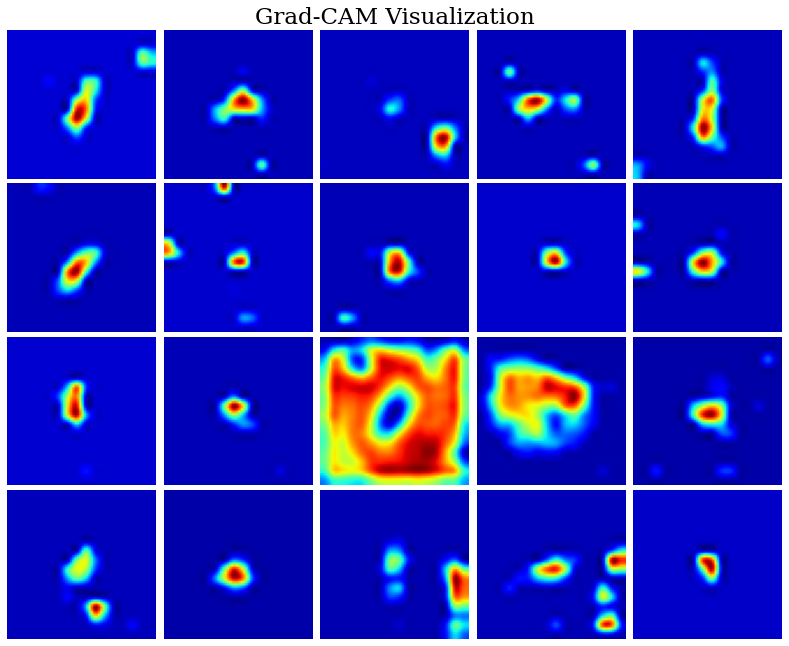

In [32]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Grad-CAM Visualization",fontsize=23)
    plt.subplot(n_rows, n_cols, i+1)
    grads = visualize_cam(model, layer_idx, filter_indices=0, 
                              seed_input=X_misc_HSC_LSBG[i], penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None)
    plt.imshow(grads,cmap='viridis')
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/Misclass_LSBG_Examples_HSC_GradCAM.pdf")
#files.download("/content/drive/My Drive/Plots/Misclass_LSBG_Examples_HSC_GradCAM.pdf")
plt.show()